In [1]:
# parameters = dict(trainer.model.named_parameters())

import sys   
sys.path.append('../')        
from my_package.data import get_all_model_paths, get_all_checkpoints
from my_package.utils import load_model
from matplotlib import pyplot as plt
import copy

LOAD_MODEL_PATH = '../../models/test_cp_debias_mask_lr_0.0025_recent_baseline/' 

# compile model here from all checkpoints
checkpoints = get_all_checkpoints(LOAD_MODEL_PATH)

/ist-project/scads/can_sit/xx_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = checkpoints[-1]

In [3]:
import yaml
from transformers import AutoTokenizer, BertForSequenceClassification

config_path = "../configs/pcgu_config.yaml"

with open(config_path, "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    print(f'config: {config_path}')
model_name  =  '../../bert-base-uncased-mnli/'
# model = SequenceClassificationTransformer.from_pretrained(model_name, num_labels = 3)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = len(config['label_maps'].keys()))

config: ../configs/pcgu_config.yaml


In [4]:
import torch 
cur_model = copy.deepcopy(model)
cur_model.load_state_dict(torch.load(path)) 

<All keys matched successfully>

bert.encoder.layer.2.intermediate.dense.weight


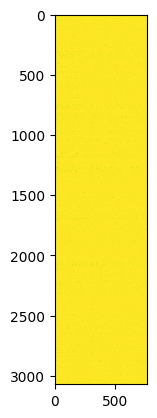

bert.encoder.layer.2.attention.output.dense.weight


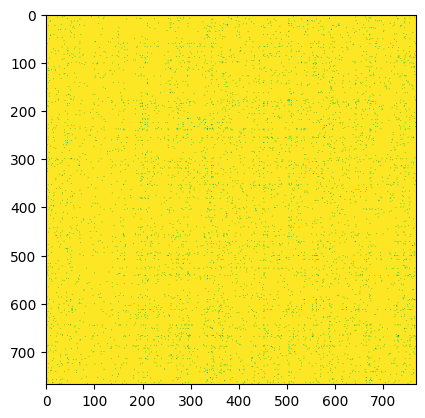

In [5]:
parameters = dict(cur_model.named_parameters())
param_names = ["bert.encoder.layer.2.intermediate.dense.weight",
               "bert.encoder.layer.2.attention.output.dense.weight"]

for param_name in param_names:          
    w = parameters[param_name]
    print(param_name)

    plt.imshow((w != 0).detach().cpu())
    plt.show()


In [6]:
import torch
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
from learn_mask.sparse_trainer import SparseTrainer
from learn_mask.hf_model import SequenceClassificationTransformer
from nn_pruning.patch_coordinator import ModelPatchingCoordinator, SparseTrainingArguments
import yaml

mask_model = SequenceClassificationTransformer.from_pretrained(model_name, num_labels = 3)

In [7]:
config_path = '../configs/learn_mask/unstructured_sigmoid.yaml'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open(config_path, "r") as yamlfile:
    sparse_args = yaml.load(yamlfile, Loader=yaml.FullLoader)


sparse_args = SparseTrainingArguments(**sparse_args)
# patch model
model_patcher = ModelPatchingCoordinator(
        sparse_args= sparse_args,
        device=device,
        cache_dir="tmp/",  # Used only for teacher
        logit_names="logits",  # TODO
        teacher_constructor=None,  # TODO
)

model_patcher.patch_model(mask_model)
model_patcher.schedule_threshold(True)


../../models/cp_debias_mask_lr_0.0025_recent_baseline/seed_1548/checkpoint-140000/pytorch_model.bin


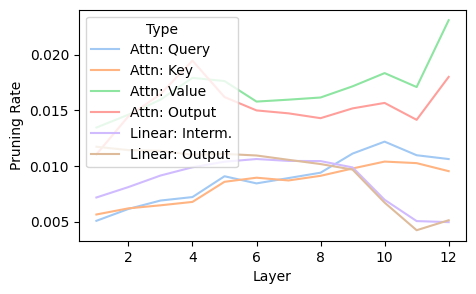

In [8]:
# mask path 
LOAD_MASK_MODEL_PATH = '../../models/cp_debias_mask_lr_0.0025_recent_baseline/'
checkpoints = get_all_checkpoints(LOAD_MASK_MODEL_PATH)
cur_model = copy.deepcopy(mask_model)

path = checkpoints[0]
print(path)
cur_model.load_state_dict(torch.load(path)) 

from nn_pruning.modules.masked_nn import MaskedLinear
modules = {}; masks = {}
for name, module in cur_model.named_modules():
    if type(module) == MaskedLinear:
        modules[name] = module
        masks[name] = module.mask_module(module.weight, 0.1).detach().numpy()
        
from collections import defaultdict
import numpy as np 
import pandas as pd 
sparsities = defaultdict(list)
for key in masks:
    components = key.split(".")
    layer_num = components[3]
    if components[4] == "attention":
        layer_type = components[6]
    else:
        layer_type = components[4]
    mask = masks[key]
    sparsity = np.mean(mask).item()
    sparsities[layer_type].append(sparsity)

# for name in sparsities:
#     plt.plot(sparsities[name], label=name)
# plt.legend()
# plt.savefig("sparsity.pdf", format="pdf")
# plt.show()

import seaborn as sns
data = []
name_mapping = {
    "query" : "Attn: Query",
    "key" : "Attn: Key",
    "value" : "Attn: Value",
    "dense" : "Attn: Output",
    "intermediate" : "Linear: Interm.",
    "output": "Linear: Output",
}
for name in sparsities:
    for layer in range(12):
        data.append([name_mapping[name], layer + 1, 1 - sparsities[name][layer]])
data = pd.DataFrame(data, columns=["Type", "Layer", "Pruning Rate"])
sns.set_palette('pastel')
plt.figure(figsize=(5, 3))
sns.lineplot(data=data, x="Layer", y="Pruning Rate", hue="Type")
plt.savefig("pruning_rate.pdf", format="pdf", bbox_inches="tight")


../../models/cp_debias_mask_lr_0.025_recent_baseline/seed_1548/checkpoint-140000/pytorch_model.bin


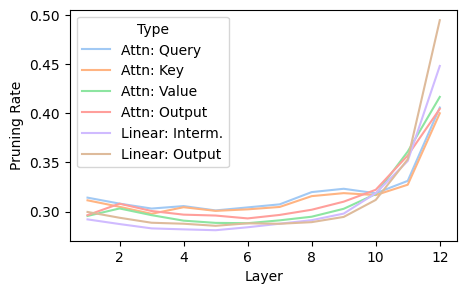

In [9]:
# mask path 
LOAD_MASK_MODEL_PATH = '../../models/cp_debias_mask_lr_0.025_recent_baseline'
checkpoints = get_all_checkpoints(LOAD_MASK_MODEL_PATH)

path = checkpoints[0]
print(path)

cur_model = copy.deepcopy(mask_model)
cur_model.load_state_dict(torch.load(path)) 

from nn_pruning.modules.masked_nn import MaskedLinear
modules = {}; masks = {}
for name, module in cur_model.named_modules():
    if type(module) == MaskedLinear:
        modules[name] = module
        masks[name] = module.mask_module(module.weight, 0.1).detach().numpy()
        
from collections import defaultdict
import numpy as np 
sparsities = defaultdict(list)

for key in masks:
    components = key.split(".")
    layer_num = components[3]
    if components[4] == "attention":
        layer_type = components[6]
    else:
        layer_type = components[4]
    mask = masks[key]
    sparsity = np.mean(mask).item()
    sparsities[layer_type].append(sparsity)

# for name in sparsities:
#     plt.plot(sparsities[name], label=name)
# plt.legend()
# plt.savefig("sparsity.pdf", format="pdf")
# plt.show()

import seaborn as sns
data = []
name_mapping = {
    "query" : "Attn: Query",
    "key" : "Attn: Key",
    "value" : "Attn: Value",
    "dense" : "Attn: Output",
    "intermediate" : "Linear: Interm.",
    "output": "Linear: Output",
}
for name in sparsities:
    for layer in range(12):
        data.append([name_mapping[name], layer + 1, 1 - sparsities[name][layer]])
data = pd.DataFrame(data, columns=["Type", "Layer", "Pruning Rate"])
sns.set_palette('pastel')
plt.figure(figsize=(5, 3))
sns.lineplot(data=data, x="Layer", y="Pruning Rate", hue="Type")
plt.savefig("pruning_rate.pdf", format="pdf", bbox_inches="tight")

../../models/cp_debias_mask_lr_0.01_recent_baseline/seed_1548/checkpoint-140000/pytorch_model.bin


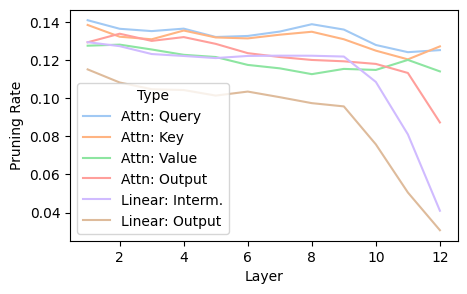

In [10]:
# mask path 
LOAD_MASK_MODEL_PATH = '../../models/cp_debias_mask_lr_0.01_recent_baseline/'
checkpoints = get_all_checkpoints(LOAD_MASK_MODEL_PATH)
path = checkpoints[-1]
print(path)
cur_model = copy.deepcopy(mask_model)
cur_model.load_state_dict(torch.load(path)) 

from nn_pruning.modules.masked_nn import MaskedLinear
modules = {}; masks = {}
for name, module in cur_model.named_modules():
    if type(module) == MaskedLinear:
        modules[name] = module
        masks[name] = module.mask_module(module.weight, 0.1).detach().numpy()
        
from collections import defaultdict
import numpy as np 
sparsities = defaultdict(list)
for key in masks:
    components = key.split(".")
    layer_num = components[3]
    if components[4] == "attention":
        layer_type = components[6]
    else:
        layer_type = components[4]
    mask = masks[key]
    sparsity = np.mean(mask).item()
    sparsities[layer_type].append(sparsity)

# for name in sparsities:
#     plt.plot(sparsities[name], label=name)
# plt.legend()
# plt.savefig("sparsity.pdf", format="pdf")
# plt.show()
import seaborn as sns
data = []
name_mapping = {
    "query" : "Attn: Query",
    "key" : "Attn: Key",
    "value" : "Attn: Value",
    "dense" : "Attn: Output",
    "intermediate" : "Linear: Interm.",
    "output": "Linear: Output",
}
for name in sparsities:
    for layer in range(12):
        data.append([name_mapping[name], layer + 1, 1 - sparsities[name][layer]])
data = pd.DataFrame(data, columns=["Type", "Layer", "Pruning Rate"])
sns.set_palette('pastel')
plt.figure(figsize=(5, 3))
sns.lineplot(data=data, x="Layer", y="Pruning Rate", hue="Type")
plt.savefig("pruning_rate.pdf", format="pdf", bbox_inches="tight")